In [1]:
#pip install mlxtend  # Satranc tahtasını cizdirmek icin

In [2]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from mlxtend.plotting import checkerboard_plot

In [3]:
N_N = 8 # board size
MONTE_CARLO_TREE_DEPTH = 10 # Her bir hamle için kaç kere sona kadar oynayacak

In [4]:
def create_board():
    chess_board = np.zeros((N_N, N_N))-1 # -1 yani boş karelerden oluşan bir tahta oluşturuyor
    return chess_board

In [5]:
def fill_board(board,pieces_columns): # Tahtayı rastgele doldurma fonksiyonu
    remove_king = False #Şahı bir kere kullanmak için tuttuğum değişken
    remove_queen = False
    queen_count = 0
    for i in range(N_N):
        for j in range(N_N):           
            if random.choice([0,1,2,3,4]) <= 1:   # %40 ihtimalle dolduruyor
                board[i][j] = random.choice(pieces_columns)
                if board[i][j] == 5:
                    remove_king = True  
                    pieces_columns.pop() # Sah sadece 1 tane olması icin
                if board[i][j] == 4: # Eğer yeni gelen taş vezirse ve vezir sayısı 2 den fazlaysa vezir yerine başka taş ekle
                    if queen_count < 1: # Problemi zorlaştırmak amaçlı eklenmiştir. Opsiyoneldir.
                        queen_count += 1
                    else: 
                        remove_queen = True
                        board[i][j] = random.choice([0,1,2,3])
    if remove_queen:
        pieces_columns[4] = 4
    if remove_king:
        pieces_columns.append(5) # Eğer şahı çıkardıysa geri ekliyorum 
    return board

In [6]:
def possible_pawn_moves(board,x_pawn,y_pawn):  # Olası piyon hamlelerinin hesaplanması
    possible_moves = [] # Olası hamleler listesi
    start_point = [x_pawn,y_pawn] # Baslangıc noktası
    all_moves_pawn = [[x_pawn-1,y_pawn-1],[x_pawn-1,y_pawn+1]]
    for move in all_moves_pawn:  # Burada hamlelerin tahtadan cıkıp cıkmadıgını cıkmadıysa da oynanabilir mi kontrolu
        if ((move[0] > -1 and move[1] < 8 and move[1] > -1) and (board[move[0],move[1]] != -1)): # Sınırlar aşıldı mı?, Oynanacak karede taş var mı?
            move = start_point + move # hamle oynanabilirse baslangıc konumunu ve bitis konumunu birlestirip listeye ekliyorum.
            possible_moves.append(move)
            
    return possible_moves

In [7]:
def possible_knight_moves(board,x_pawn,y_pawn): # Olası at hamlelerinin hesaplanması
    possible_moves = [] # Olası hamleler listesi
    start_point = [x_pawn,y_pawn] # Baslangıc noktası
    changes_knight = [[-2,-1],[-2,+1],[-1,+2],[+1,+2],[+2,+1],[+2,-1],[+1,-2],[-1,-2]] # at hareket ettiğinde x ve y nin nasıl değişeceği belirleniyor.   
    all_moves_knight = []
    
    for change in changes_knight:   # Baslangıc konumuna degisiklikler ekleniyor ve olası hareketler listeleniyor
        start_point = [x_pawn,y_pawn]
        new_place = [start_point[0]+change[0],start_point[1]+change[1]]
        all_moves_knight.append(new_place)
    
    for move in all_moves_knight:  # burada olası hamlelerin tahtadan cıkıp cıkmadıgını ve cıkmadıysa oynanabilir mi kontrolu
        if (move[0] > -1 and move[0] < 8 and move[1] > -1 and move[1] < 8) and (board[move[0],move[1]] != -1):
            move = start_point + move
            possible_moves.append(move)
    return possible_moves  

In [8]:
def possible_bishop_moves(board,x_pawn,y_pawn): # Olası fil hamlelerinin hesaplanması
    start_point = [x_pawn,y_pawn] # Baslangıc noktası
    all_moves_bishop = []
    possible_moves = []
    LT_cont = False   # Fil çapraza doğru giderken sadece ilk denk geldiği taşı yiyebileceğinden, sonraki taşlara bakmama kontrolü
    LB_cont = False   # Fil 4 ayrı yöne gidebildiğinden, dört aytı yöne özel kontrol yapılıyor.
    RT_cont = False
    RB_cont = False
    
    for i in range(1,N_N):  # Her bir adımda filin bir ilerideki çaprazı kontrol edilerek, olası hamleler çıkarılıyor.
        left_top = [start_point[0]-i,start_point[1]-i]
        right_top = [start_point[0]-i,start_point[1]+i]
        left_bot = [start_point[0]+i,start_point[1]-i]
        right_bot = [start_point[0]+i,start_point[1]+i]
        
        if (LT_cont == False) and (left_top[0]>-1 and left_top[0]<8 and left_top[1] > -1 and left_top[1] < 8) and (board[left_top[0]][left_top[1]] != -1):
            move = start_point + left_top
            possible_moves.append(move)
            LT_cont = True
        if (LB_cont == False) and (left_bot[0]>-1 and left_bot[0]<8 and left_bot[1] > -1 and left_bot[1] < 8) and (board[left_bot[0]][left_bot[1]] != -1):
            move = start_point + left_bot
            possible_moves.append(move)
            LB_cont = True
        if (RT_cont == False) and (right_top[0]>-1 and right_top[0]<8 and right_top[1] > -1 and right_top[1] < 8) and (board[right_top[0]][right_top[1]] != -1):
            move = start_point + right_top
            possible_moves.append(move)
            RT_cont = True
        if (RB_cont == False) and (right_bot[0]>-1 and right_bot[0]<8 and right_bot[1] > -1 and right_bot[1] < 8) and (board[right_bot[0]][right_bot[1]] != -1):
            move = start_point + right_bot
            possible_moves.append(move)
            RB_cont = True
    
    return possible_moves   

In [9]:
def possible_rook_moves(board,x_pawn,y_pawn): # Olası kale hamleleri
    start_point = [x_pawn,y_pawn] # Baslangıc noktası
    possible_moves = [] # Olası hamleler listesi
    
    left_cont = False
    right_cont = False  # Kale 4 yöne gidip ilk gördüğü taşı alabildiğinden, taş alıp alamayacağı kontrolü.
    top_cont = False
    bot_cont = False
    
    for i in range(1,N_N): # Her aşamada bir ilerideki kare kontrol edilir. Taş alınabiliyorsa listeye eklenir.
        left = [start_point[0],start_point[1]-i]
        right = [start_point[0],start_point[1]+i]
        top = [start_point[0]-i,start_point[1]]
        bot = [start_point[0]+i,start_point[1]]
        
        
        if (left_cont == False) and (left[1] > -1 and left[1] < 8) and (board[left[0]][left[1]] != -1): # Sınırlar aşıldı mı?, Oynanacak karede taş var mı?
            move = start_point + left
            possible_moves.append(move)
            left_cont = True
        if (right_cont == False) and (right[1] > -1 and right[1] < 8) and (board[right[0]][right[1]] != -1):
            move = start_point + right
            possible_moves.append(move)
            right_cont = True
        if (top_cont == False) and (top[0] > -1 and top[0] < 8) and (board[top[0]][top[1]] != -1):
            move = start_point + top
            possible_moves.append(move)
            top_cont = True
        if (bot_cont == False) and (bot[0] > -1 and bot[0] < 8) and (board[bot[0]][bot[1]] != -1):
            move = start_point + bot
            possible_moves.append(move)
            bot_cont = True
            
    return possible_moves 

In [10]:
def possible_queen_moves(board,x_pawn,y_pawn): # # Olası vezir hamleleri, fil ve kalenin karışımı
    start_point = [x_pawn,y_pawn]
    all_moves_queen = []
    possible_moves = []
    
    LT_cont = False   # Her yönde taş alabilir mi alamaz mı kontrolü.
    LB_cont = False
    RT_cont = False
    RB_cont = False
    left_cont = False
    right_cont = False
    top_cont = False
    bot_cont = False
    
    for i in range(1,N_N):
        left = [start_point[0],start_point[1]-i]
        right = [start_point[0],start_point[1]+i]
        top = [start_point[0]-i,start_point[1]]
        bot = [start_point[0]+i,start_point[1]]
        left_top = [start_point[0]-i,start_point[1]-i]
        right_top = [start_point[0]-i,start_point[1]+i]
        left_bot = [start_point[0]+i,start_point[1]-i]
        right_bot = [start_point[0]+i,start_point[1]+i]
        
        
        if (left_cont == False) and (left[1] > -1 and left[1] < 8) and (board[left[0]][left[1]] != -1):
            move = start_point + left
            possible_moves.append(move)
            left_cont = True
        if (right_cont == False) and (right[1] > -1 and right[1] < 8) and (board[right[0]][right[1]] != -1):
            move = start_point + right
            possible_moves.append(move)
            right_cont = True
        if (top_cont == False) and (top[0] > -1 and top[0] < 8) and (board[top[0]][top[1]] != -1):
            move = start_point + top
            possible_moves.append(move)
            top_cont = True
        if (bot_cont == False) and (bot[0] > -1 and bot[0] < 8) and (board[bot[0]][bot[1]] != -1):
            move = start_point + bot
            possible_moves.append(move)
            bot_cont = True
        if (LT_cont == False) and (left_top[0]>-1 and left_top[0]<8 and left_top[1] > -1 and left_top[1] < 8) and (board[left_top[0]][left_top[1]] != -1):
            move = start_point + left_top
            possible_moves.append(move)
            LT_cont = True
        if (LB_cont == False) and (left_bot[0]>-1 and left_bot[0]<8 and left_bot[1] > -1 and left_bot[1] < 8) and (board[left_bot[0]][left_bot[1]] != -1):
            move = start_point + left_bot
            possible_moves.append(move)
            LB_cont = True
        if (RT_cont == False) and (right_top[0]>-1 and right_top[0]<8 and right_top[1] > -1 and right_top[1] < 8) and (board[right_top[0]][right_top[1]] != -1):
            move = start_point + right_top
            possible_moves.append(move)
            RT_cont = True
        if (RB_cont == False) and (right_bot[0]>-1 and right_bot[0]<8 and right_bot[1] > -1 and right_bot[1] < 8) and (board[right_bot[0]][right_bot[1]] != -1):
            move = start_point + right_bot
            possible_moves.append(move)
            RB_cont = True
    
    return possible_moves

In [11]:
def possible_king_moves(board,x_pawn,y_pawn): # Olası şah hamleleri
    start_point = [x_pawn,y_pawn]
    possible_moves = []
    changes_king = [[-1,0],[-1,+1],[0,+1],[+1,+1],[+1,0],[+1,-1],[0,-1],[-1,-1]] # Şah hareket ettiğinde x ve y nin nasıl değişeceği    
    
    all_moves_king = []
    
    for change in changes_king:   # Burada baslangıc konumuna degisiklikleri ekliyorum olası hareketleri listeliyorum
        start_point = [x_pawn,y_pawn]
        new_place = [start_point[0]+change[0],start_point[1]+change[1]]
        all_moves_king.append(new_place)
        
    for move in all_moves_king:  # Burada olası hamlelerin tahtadan cıkıp cıkmadıgını ve cıkmadıysa oynanabilir mi kontrolu yapılıyor.
        if (move[0] > -1 and move[0] < 8 and move[1] > -1 and move[1] < 8) and (board[move[0],move[1]] != -1):
            move = start_point + move
            possible_moves.append(move)
    return possible_moves  

In [12]:
def find_possible_moves(board):  # Tüm olası hamlelerin bulunduğu fonksiyon
    possible_moves = []  # Tüm olası hamlelerin tutulduğu liste
    new_posibility = None # O karedeki taşın olası hamlesi var mı yok mu buradan belli olur.
    for i in range(N_N):
        for j in range(N_N):
            new_posibility = None
            if board[i][j] == 0: # Eğer piyonsa
                new_posibility = possible_pawn_moves(board,i,j)
            elif board[i][j] == 1:  # Eğer at ise
                new_posibility = possible_knight_moves(board,i,j)
            elif board[i][j] == 2:  # Eğer fil ise
                new_posibility = possible_bishop_moves(board,i,j)
            elif board[i][j] == 3:  # Eğer kale ise
                new_posibility = possible_rook_moves(board,i,j)
            elif board[i][j] == 4:  # Eğer vezir ise
                new_posibility = possible_queen_moves(board,i,j)
            elif board[i][j] == 5:  # Eğer şah ise
                new_posibility = possible_king_moves(board,i,j)
                
                
            if new_posibility != None: # new_posibility array içinde array olarak döner. dolayısıyla sırayla possible_moves'a eklenir.
                for pos_move in new_posibility:
                    possible_moves.append(pos_move)
                        
    return possible_moves

In [13]:
def play_move(board,move): # Girilen hamleyi oynayan fonksiyon, tahtayı yapılan hamleye göre günceller
    board[move[2]][move[3]] = board[move[0]][move[1]]
    board[move[0]][move[1]] = -1
    return board

In [14]:
def count_pieces_on_board(board): # Tahtada kaç adet taş kaldığı hesaplanır.
    count = 0
    for i in range(N_N):
        for j in range(N_N):
            if board[i][j] != -1: # Eğer kare -1 değilse, taştır
                count = count + 1
                
    return count

In [15]:
def monte_carlo_search(board,selected_copy_move): # monte carlo search yapar ve son durumlarda kaç taş kaldığının ortalamasını döndürür
    
    possible_moves_copy = [] # Her hamle oynandıktan sonra yeni olası hamleleri tutar
    values_of_copies = np.zeros(MONTE_CARLO_TREE_DEPTH) # Her turad son durumda kaç taş kaldığını tutar
    
    for i in range(MONTE_CARLO_TREE_DEPTH): # Seçilen hamle için MONTE_CARLO_TREE_DEPTH kere sona kadar oynar
        copy_board = board.copy()
        copy_board = play_move(copy_board,selected_copy_move)   
        possible_moves_copy = find_possible_moves(copy_board)
        
        while len(possible_moves_copy) > 0:  # Oyun bitene kadar random hamle seçimi yapar
            random_move = random.choice(possible_moves_copy)
            copy_board = play_move(copy_board,random_move) # seçilen random hamle oynanır
            possible_moves_copy = find_possible_moves(copy_board) # oynanan random hamleden sonra yeni oluşan konumun olası hamlelerini hesaplar
            
        values_of_copies[i] = count_pieces_on_board(copy_board) # Tahtada son durumda kaç taş olduğu tutulur
    
    avg_copies = sum(values_of_copies) / MONTE_CARLO_TREE_DEPTH # Bu hamle için yapılan MONTE_CARLO_TREE_DEPTH kadar denemede ortalama kaç taş kaldığını döndürür
    return avg_copies

In [16]:
def play_game(possible_moves,moves_played,board):  # Oyunu baştan sona oynayan fonksiyon
    
    print('Starting position of the game')   # Tahtanın ilk pozisyonu yazdırılır
    brd = checkerboard_plot(board,fmt = '%d',figsize=(5, 5))
    plt.show()
    
    while len(possible_moves) > 0: # Olası hamle kalmayana kadar, yani oyun bitene kadar

        values_of_moves = np.zeros(len(possible_moves)) # Hamlelerin monte_carlo_search sonucu ortalama kaç taş kaldığını tutar.

        for i in range(len(possible_moves)): # Tüm hamleleri gezer tek tek monte carlo uygulanır

            copy_board = board.copy()
            values_of_moves[i] = monte_carlo_search(copy_board,possible_moves[i]) # monte_carlo_search hamleye uygulanır

        min_value = min(values_of_moves) # Ortlama kalan taş değeri en düşük olan hamle, yapılacak hamle olarak seçilir
        index_of_minimum = np.where(values_of_moves == min_value)
        min_index = index_of_minimum[0][0]
        selected_move = possible_moves[min_index]
        
        
        piece_moved = pieces[int(board[selected_move[0]][selected_move[1]])] # hangi tas ile hamle yapıldığını göstermek amaçlı
        board = play_move(board,selected_move) # Hamle yapılır, tahta güncellenir
        moves_played.append(selected_move) # Oynanan hamleler listesine ekleme yapılır
        possible_moves = find_possible_moves(board) # Tahtanın yeni pozisyonunun olası hamleleri çıkarılır
        print_board(board,selected_move,piece_moved) # Her hamlede tahta gösterilir
        
    return board

In [17]:
def print_board(board,selected_move,piece_moved): # Tahta yazdırılır ve hangi hamlenin oynandığı yazar 
    
    print(piece_moved,selected_move[0],'-', selected_move[1],' to ',selected_move[2],'-',selected_move[3],' move selected and played')
    
    new_board = board.copy()       
    brd = checkerboard_plot(new_board,fmt = '%d',figsize=(5, 5))
    plt.show()   

In [18]:
pieces = ['Pawn','Knight','Bishop','Rook','Queen','King'] # Taşlar tanımlandı
pieces_columns = [0,1,2,3,4,5]

board = create_board() # Board oluşturuldu

board = fill_board(board,pieces_columns) # Board rastgele dolduruldu

init_board = board.copy()# baslangıc durumundaki tahtayı kaybetmemek icin bir kopyası olusturuldu

Starting position of the game


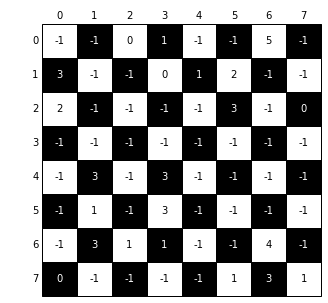

Rook 2 - 5  to  1 - 5  move selected and played


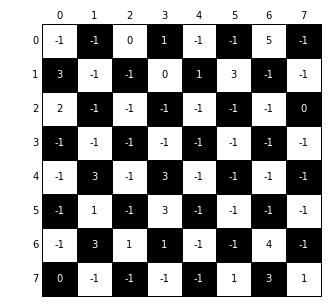

Rook 4 - 3  to  5 - 3  move selected and played


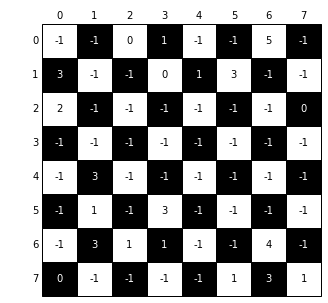

Rook 1 - 0  to  2 - 0  move selected and played


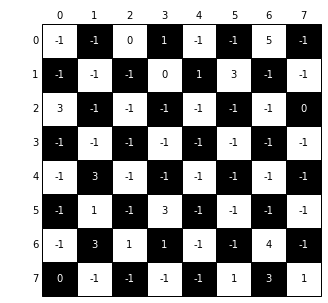

Knight 5 - 1  to  7 - 0  move selected and played


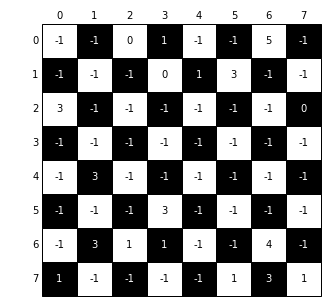

Rook 1 - 5  to  7 - 5  move selected and played


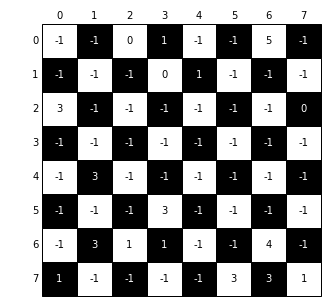

Pawn 1 - 3  to  0 - 2  move selected and played


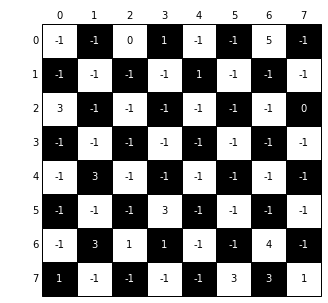

Queen 6 - 6  to  7 - 5  move selected and played


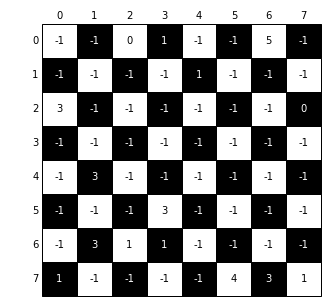

Rook 4 - 1  to  6 - 1  move selected and played


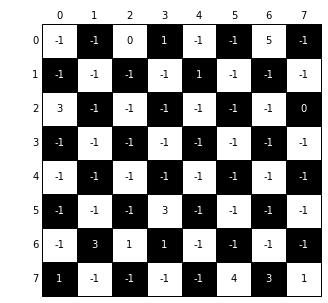

Rook 6 - 1  to  6 - 2  move selected and played


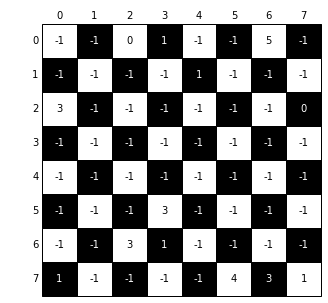

Queen 7 - 5  to  5 - 3  move selected and played


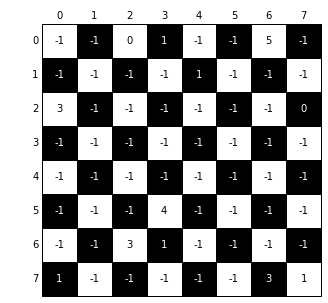

Knight 1 - 4  to  0 - 6  move selected and played


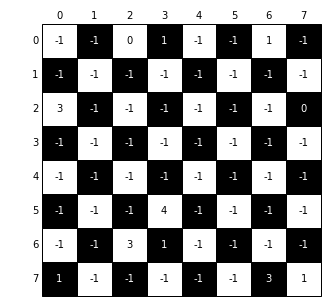

Queen 5 - 3  to  2 - 0  move selected and played


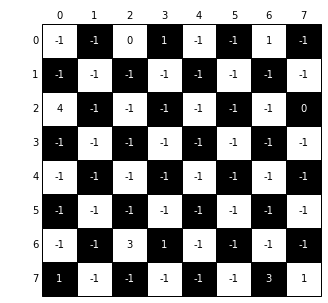

Rook 7 - 6  to  7 - 0  move selected and played


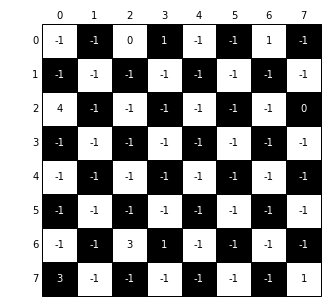

Queen 2 - 0  to  7 - 0  move selected and played


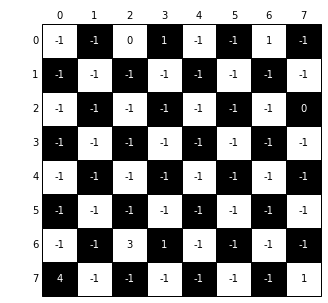

Rook 6 - 2  to  0 - 2  move selected and played


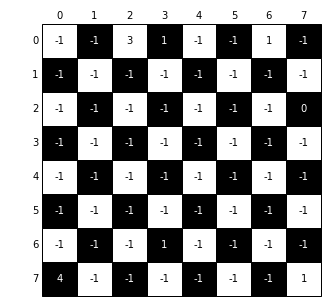

Knight 0 - 6  to  2 - 7  move selected and played


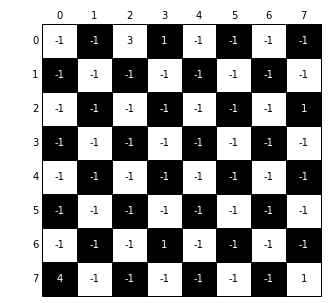

Rook 0 - 2  to  0 - 3  move selected and played


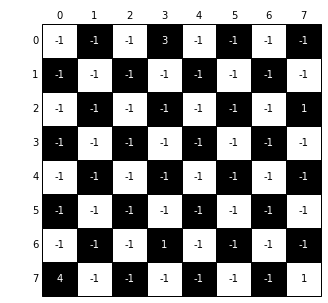

Rook 0 - 3  to  6 - 3  move selected and played


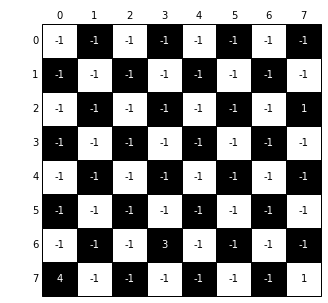

Queen 7 - 0  to  7 - 7  move selected and played


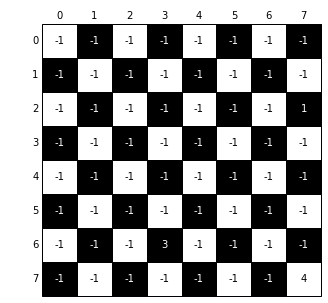

Queen 7 - 7  to  2 - 7  move selected and played


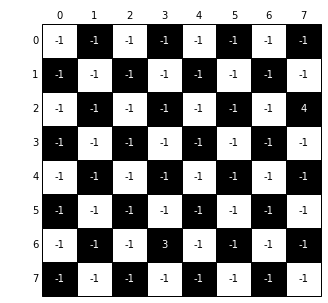

Queen 2 - 7  to  6 - 3  move selected and played


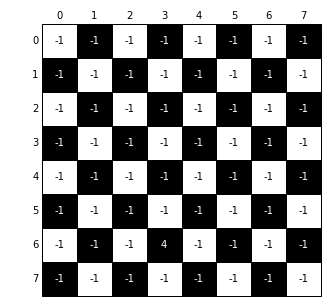

Piece count at the final position 1


In [19]:
possible_moves = [] # Olası hamle listesi oluşturuldu
moves_played = [] # Oynanan hamlelerin tutulduğu liste oluşturuldu
possible_moves = find_possible_moves(board) # İlk durumda olası hamleler listelendi


final_board = play_game(possible_moves,moves_played,board) # Oyun oynandı
print('Piece count at the final position',count_pieces_on_board(final_board)) # Son durumda tahtada kaç taş kaldığı yazdırıldı

In [20]:
moves_played # Hangi Hamleler oynandı

[[2, 5, 1, 5],
 [4, 3, 5, 3],
 [1, 0, 2, 0],
 [5, 1, 7, 0],
 [1, 5, 7, 5],
 [1, 3, 0, 2],
 [6, 6, 7, 5],
 [4, 1, 6, 1],
 [6, 1, 6, 2],
 [7, 5, 5, 3],
 [1, 4, 0, 6],
 [5, 3, 2, 0],
 [7, 6, 7, 0],
 [2, 0, 7, 0],
 [6, 2, 0, 2],
 [0, 6, 2, 7],
 [0, 2, 0, 3],
 [0, 3, 6, 3],
 [7, 0, 7, 7],
 [7, 7, 2, 7],
 [2, 7, 6, 3]]

In [21]:
#board = init_board